In [1]:
import io
import gzip

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker
from matplotlib.lines import Line2D

from IPython.display import display, Markdown, Latex,  Math

mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["figure.autolayout"] = False

import kymatio
#from kymatio.torch import Scattering2D
from kymatio import Scattering2D
import torch

from astropy.io import fits

In [2]:
#!pip install pyarrow --upgrade --user
#!pip install pandas --upgrade --user

In [3]:
import pyarrow
pyarrow.__version__

'2.0.0'

In [4]:
def extract_numpy_2d_array(stamp: bytes) -> np.array:
    """ extract one cutout contained in an alert (2D array)

      Parameters
      ----------
      stamp: bytes
        Cutout data as raw binary from the alert
    """
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            data=hdul[0].data[::-1]
    return data

In [5]:
pdf = pd.read_parquet('./cutouts_je/Early_SN_candidate/')


In [6]:
# observations
all_science = pdf['cutoutScience'].values

# images de reference
all_template = pdf['cutoutTemplate'].values

# difference entre les 2 precedents
all_difference = pdf['cutoutDifference'].values

# lit les images de la 1ere alerte N=len(all_science),H=60 pixels,W=60 pixels
all_science_numpy = np.array([extract_numpy_2d_array(i) for i in all_science])
all_template_numpy = np.array([extract_numpy_2d_array(i) for i in all_template])
all_difference_numpy = np.array([extract_numpy_2d_array(i) for i in all_difference])


In [7]:
all_science_numpy.shape

(111, 63, 63)

In [8]:
# N C H W
imgs = np.concatenate((all_science_numpy[:,np.newaxis],all_template_numpy[:,np.newaxis],all_difference_numpy[:,np.newaxis]),axis=1)

In [9]:
imgs = imgs.reshape(-1,63,63)

In [10]:
imgs.shape

(333, 63, 63)

In [11]:
imgs = np.pad(imgs[:],((0,0),(0,1),(0,1)),'reflect')

In [12]:
imgs.shape

(333, 64, 64)

In [13]:
imgs = imgs.reshape(-1,3,64,64)

In [14]:
imgs.shape

(111, 3, 64, 64)

In [15]:
t_imgs=torch.from_numpy(imgs.copy())

In [16]:
t_imgs.shape

torch.Size([111, 3, 64, 64])

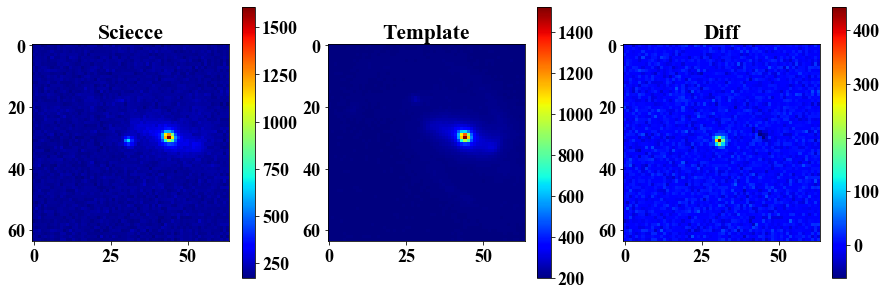

In [84]:
fig, axs = plt.subplots(figsize=(15,5), nrows=1,ncols=3)
img0=axs[0].imshow(imgs[0,0])
axs[0].set_title("Sciecce")

img1=axs[1].imshow(imgs[0,1])
axs[1].set_title("Template")

img2=axs[2].imshow(imgs[0,2])
axs[2].set_title("Diff")

fig.colorbar(img0, ax=axs[0])
fig.colorbar(img1, ax=axs[1])
fig.colorbar(img2, ax=axs[2])


# Premiers tests avec une reduction modeste de l'information -> images

In [50]:
shape = 64,64
J=2 # was 6
L=4
max_ord=1 # was qd J=6
S = Scattering2D(J=J,shape=shape,L=L, max_order=max_ord)

/Users/campagne/anaconda3/lib/python3.7/site-packages/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


In [45]:
coeffs=S(t_imgs)

In [46]:
coeffs.shape

torch.Size([111, 3, 9, 16, 16])

In [47]:
tmp=np.squeeze(coeffs)

In [48]:
#N 3 K=1+J*L+L^2 J(J-1)/2
K1=1+J*L # max order =1
K=1+J*L+L**2*J*(J-1)//2  # max order =2
print(K1,K)
tmp.shape

9 25


torch.Size([111, 3, 9, 16, 16])

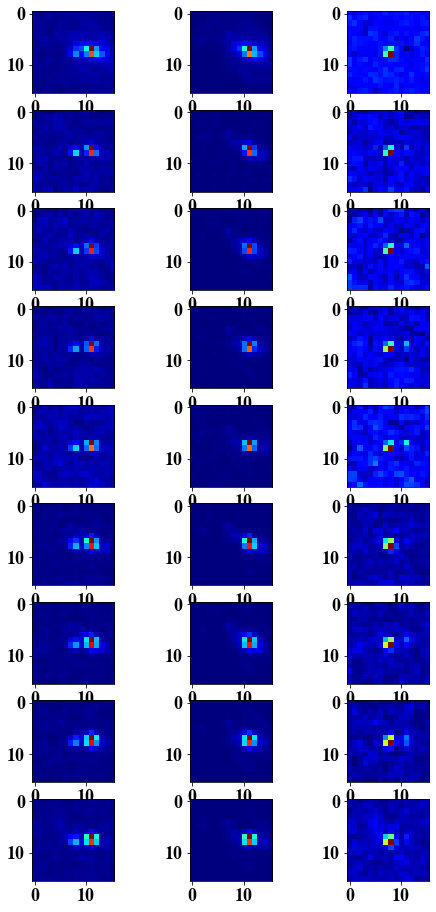

In [49]:
ialert=0
fig, axs = plt.subplots(figsize=(8,16), nrows=tmp.shape[2],ncols=3)
for irow in range(tmp.shape[2]):
    #science
    axs[irow,0].imshow(tmp[ialert,0,irow])
    #template
    axs[irow,1].imshow(tmp[ialert,1,irow])
    #diff
    axs[irow,2].imshow(tmp[ialert,2,irow])


# Reduction maximale de l'information -> courbes

In [63]:
shape = 64,64
J=6
L=4
S1 = Scattering2D(J=J,shape=shape,L=L, max_order=1)
S2 = Scattering2D(J=J,shape=shape,L=L, max_order=2)

/Users/campagne/anaconda3/lib/python3.7/site-packages/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)
/Users/campagne/anaconda3/lib/python3.7/site-packages/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


In [64]:
coeffs1=S1(t_imgs)
coeffs2=S2(t_imgs)


In [68]:
coeffs1.shape, coeffs2.shape

(torch.Size([111, 3, 25, 1, 1]), torch.Size([111, 3, 265, 1, 1]))

In [70]:
tmp1=np.squeeze(coeffs1)
tmp2=np.squeeze(coeffs2)

In [72]:
#N 3 K=1+J*L+L^2 J(J-1)/2
K1=1+J*L # max order =1
K=1+J*L+L**2*J*(J-1)//2  # max order =2
print(K1,K)
tmp1.shape, tmp2.shape


25 265


(torch.Size([111, 3, 25]), torch.Size([111, 3, 265]))

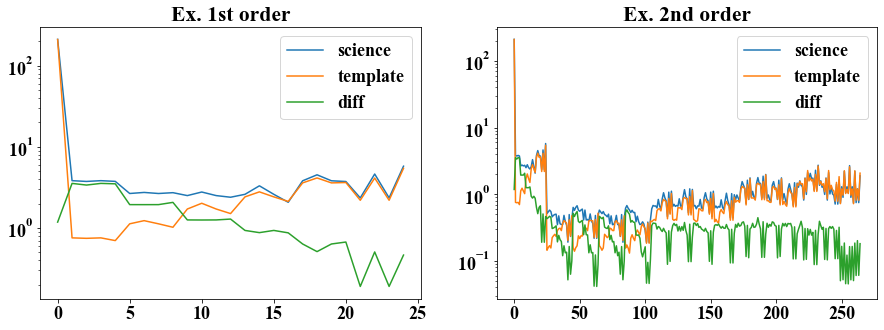

In [77]:
fig, axs = plt.subplots(figsize=(15,5), nrows=1,ncols=2)
axs[0].plot(tmp1[0,0],label='science')
axs[0].plot(tmp1[0,1],label='template')
axs[0].plot(tmp1[0,2],label='diff')
#plt.plot(tmp1[0]-tmp1[1],label='diff manuelle')
axs[0].set_title("Ex. 1st order")
axs[0].set_yscale('log')
axs[0].legend()

axs[1].plot(tmp2[0,0],label='science')
axs[1].plot(tmp2[0,1],label='template')
axs[1].plot(tmp2[0,2],label='diff')
#plt.plot(tmp1[0]-tmp1[1],label='diff manuelle')
axs[1].set_title("Ex. 2nd order")
axs[1].set_yscale('log')
axs[1].legend()


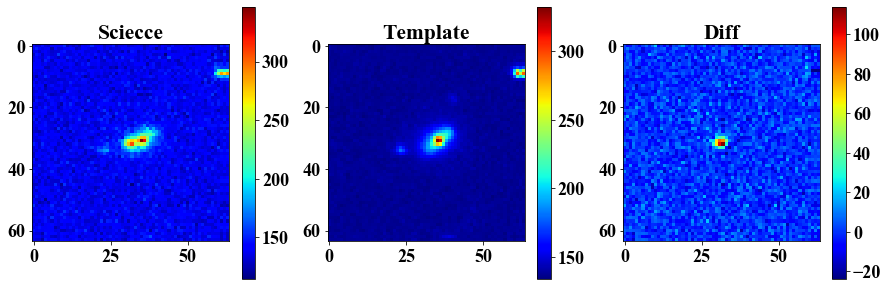

In [94]:
id=20
fig, axs = plt.subplots(figsize=(15,5), nrows=1,ncols=3)
img0=axs[0].imshow(imgs[id,0])
axs[0].set_title("Sciecce")

img1=axs[1].imshow(imgs[id,1])
axs[1].set_title("Template")

img2=axs[2].imshow(imgs[id,2])
axs[2].set_title("Diff")

fig.colorbar(img0, ax=axs[0])
fig.colorbar(img1, ax=axs[1])
fig.colorbar(img2, ax=axs[2])

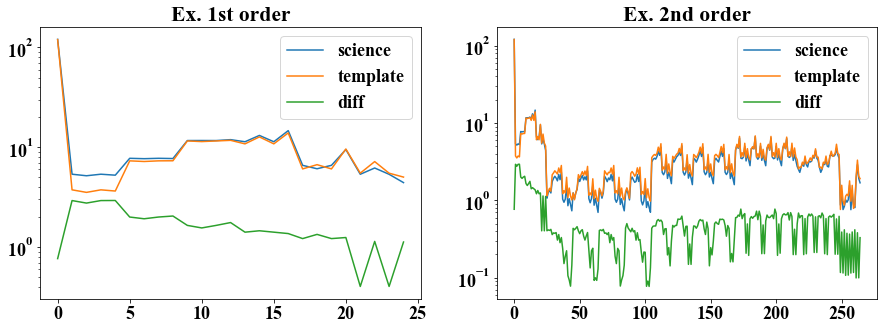

In [93]:

fig, axs = plt.subplots(figsize=(15,5), nrows=1,ncols=2)
axs[0].plot(tmp1[id,0],label='science')
axs[0].plot(tmp1[id,1],label='template')
axs[0].plot(tmp1[id,2],label='diff')
#plt.plot(tmp1[0]-tmp1[1],label='diff manuelle')
axs[0].set_title("Ex. 1st order")
axs[0].set_yscale('log')
axs[0].legend()

axs[1].plot(tmp2[id,0],label='science')
axs[1].plot(tmp2[id,1],label='template')
axs[1].plot(tmp2[id,2],label='diff')
#plt.plot(tmp1[0]-tmp1[1],label='diff manuelle')
axs[1].set_title("Ex. 2nd order")
axs[1].set_yscale('log')
axs[1].legend()
